In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from read_roi import read_roi_zip
from collections import OrderedDict, Counter
import math
import PIL
from PIL import Image
from PIL.TiffTags import TAGS
import tkinter as tk
from tkinter import filedialog
import seaborn as sns

# Read, format and save raw data from ROIs #

In [4]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and return the path to the selected file
path = Path(askdirectory)
path

WindowsPath('D:/Sofia/2021-03-26_R76S_dyn')

In [5]:
tubulin = '[Tubulin] ' r'$(\mu M)$'
tub = 'tub'

DCXconc = '[DCX] ' r'$(n M)$'
DCX = 'DCX'

investigator = 'Sofia'

In [6]:
dateloc = str(path).find("202")
date = str(path)[dateloc : dateloc+10]

folders = [x for x in path.iterdir() if x.is_dir()]
folders = [i for i in folders if (str(i)[-7:] == 'results') == True]

ch = []
conc_tub = []
conc_DCX = []
DCX_type = []

for i in folders:
    CHloc = str(i).find("CH")
    tubloc = str(i).rfind(tub)
    DCXloc = str(i).rfind(DCX)
    dcxtype = str(i).find("type")
    ch = ch + [str(i)[CHloc+2:CHloc+4]]
    conc_tub = conc_tub + [(str(i)[tubloc+3:tubloc+5])]
    conc_DCX = conc_DCX + [(str(i)[DCXloc+3:DCXloc+6])]
    DCX_type = DCX_type + [(str(i)[dcxtype+4:DCXloc-1])]

date,ch, conc_tub, conc_DCX, DCX_type

('2021-03-26',
 ['11', '14', '15', '24', '25'],
 ['06', '06', '06', '06', '06'],
 ['025', '035', '025', '100', '035'],
 ['R76S', 'R76S', 'R76S', 'R76S', 'R76S'])

In [7]:
tub_conc =  [float(i) for i in conc_tub]
DCX_conc =  [float(i) for i in conc_DCX]
frame_analyzer = pd.read_csv(path/'frame_rates_avg.csv',sep=',')
pixel =  0.107 #0.107 #0.0633
folders

[WindowsPath('D:/Sofia/2021-03-26_R76S_dyn/CH11_tub06uM_typeR76S_DCX025nM-results'),
 WindowsPath('D:/Sofia/2021-03-26_R76S_dyn/CH14_tub06uM_typeR76S_DCX035nM-results'),
 WindowsPath('D:/Sofia/2021-03-26_R76S_dyn/CH15_tub06uM_typeR76S_DCX025nM-results'),
 WindowsPath('D:/Sofia/2021-03-26_R76S_dyn/CH24_tub06uM_typeR76S_DCX100nM-results'),
 WindowsPath('D:/Sofia/2021-03-26_R76S_dyn/CH25_tub06uM_typeR76S_DCX035nM-results')]

In [8]:
#frame_analyzer = frame_analyzer.iloc[[1,3]].reset_index()
frame_analyzer

,Directory,Mean,SD,Frames,Outliers,MeanWOutliers,SDWOutliers
0,D:\Sofia\2021-03-26_R76S_dyn\CH11_tub06uM_type...,5.07,0.15,400,1,10.27,103.92
1,D:\Sofia\2021-03-26_R76S_dyn\CH14_tub06uM_type...,5.06,0.09,400,1,10.37,106.13
2,D:\Sofia\2021-03-26_R76S_dyn\CH15_tub06uM_type...,5.07,0.13,400,1,11.62,130.70
3,D:\Sofia\2021-03-26_R76S_dyn\CH24_tub06uM_type...,5.10,0.20,400,1,10.73,112.50
4,D:\Sofia\2021-03-26_R76S_dyn\CH25_tub06uM_type...,5.09,0.20,400,1,10.19,102.02


In [9]:
def open_roi_poly(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','x3','y1','y2','y3'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x'][0],'x2': roi_data[key]['x'][1],'x3': roi_data[key]['x'][2],'y1': roi_data[key]['y'][0],'y2': roi_data[key]['y'][1],'y3': roi_data[key]['y'][2]}, ignore_index=True)
    return roi_df

def open_roi_line(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','y1','y2'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x1'],'x2': roi_data[key]['x2'],'y1': roi_data[key]['y1'],'y2': roi_data[key]['y2']}, ignore_index=True)
    return roi_df

In [10]:
Length = 'Length ' r'$(\mu m)$'
Lifetime = 'Lifetime ' r'$(min)$'
GrowthRate = 'Growth Rate ' r'$(\mu m / min)$'
TimeToNucleate = 'Time to Nucleate ' r'$(min)$'
ShrinkageLength = 'Shrink Length ' r'$(\mu m)$'
ShrinkageLifetime = 'Shrink Lifetime ' r'$(min)$'
ShrinkageRate = 'Shrink Rate ' r'$(\mu m / min)$'
poly_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate)
line_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate)

In [11]:
def poly_dynamics(k):
        
    data = open_roi_poly(k,'kymoslopes.zip')
    supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data)
    pre_df = {'Date': np.full((n), date), 'Investigator': np.full((n), investigator),
              'CH': np.full((n), ch[k]),tubulin: np.full((n), tub_conc[k]),DCXconc: np.full((n), DCX_conc[k])}
    df = pd.DataFrame(pre_df) 
    
    df[Length] = abs((data['x2']-data['x1'])*pixel)
    
    data[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames-2 else np.NaN, axis=1)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x[Lifetime] != 0 else np.NaN, axis=1)
    
    df[GrowthRate] = df[Length]/df[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NAN )
    
    df[TimeToNucleate] = (data['y1']-start)*spf/60
    
    df[ShrinkageLength] = abs((data['x3']-data['x2'])*pixel)
    df[ShrinkageLifetime] = abs((data['y3']-data['y2'])*spf/60)
    df[ShrinkageLifetime] = df[ShrinkageLifetime].apply(lambda x: np.NAN if x == 0 else x)
    df[ShrinkageRate] = df[ShrinkageLength]/df[ShrinkageLifetime]
    
    df.loc[pd.isnull(df[GrowthRate]), 
           [Length,Lifetime,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate]] = np.NaN
    
    df['Rescues'] = df[[Length,ShrinkageLength]].apply(lambda x: True if abs(x[Length]-x[ShrinkageLength]) > pixel*5 else False, axis=1)
    
    df['DCX Type'] = DCX_type[k]
        
    return df

def line_dynamics(k):
        
    data = open_roi_line(k,'kymoslopes.zip')
    #data_even = data.iloc[::2].reset_index()
    #data_odd = data.iloc[1::2].reset_index()
    data_even = data
    data_odd = data
    
    supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data_even)
    pre_df = {'Date': np.full((n), date),'CH': np.full((n), ch[k]),'Concentration ' r'$(\mu M)$': np.full((n), conc[k])}
    df = pd.DataFrame(pre_df) 
    
    data_even[Length] = abs((data_even['x2']-data_even['x1'])*pixel)
    data_even[Lifetime] = abs((data_even['y2']-data_even['y1'])*spf/60)
    df[GrowthRate] = data_even[Length]/data_even[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NaN )
    
    data[Lifetime] = abs((data_odd['y2']-data_odd['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames else np.NaN, axis=1)
    
    df[Length] = df[GrowthRate]*df[Lifetime]
    
    df[TimeToNucleate] = ((data_odd[['y1','y2']].min(axis=1))-start)*spf/60
    
    df.loc[pd.isnull(df[GrowthRate]), [Length,Lifetime,TimeToNucleate]] = np.NaN
    
    df = df[['Date','CH','Concentration ' r'$(\mu M)$',Length,Lifetime,GrowthRate,TimeToNucleate]]
        
    return df

In [12]:
path.parents[0]

WindowsPath('D:/Sofia')

In [13]:
newdirectory = str(path.parents[0])+'//Data_Sheets_summer'
newmydir = Path(newdirectory)
newmydir.mkdir(exist_ok=True)

In [14]:
df = poly_dynamics(0)
for i in range(1,len(ch)):
    df0 = poly_dynamics(i)
    df = df.append(df0, ignore_index=True)

df.to_csv(path/(investigator+'_'+date +'.csv'), encoding='utf-8', index=False)
df.to_csv(newmydir/(investigator+'_'+date+'.csv'), encoding='utf-8', index=False)
df

,Date,Investigator,CH,[Tubulin] $(\mu M)$,[DCX] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues,DCX Type
0,2021-03-26,Sofia,11,6.0,25.0,2.300500,6.253000,0.367903,24.779625,2.327250,0.063375,36.721893,False,R76S
1,2021-03-26,Sofia,11,6.0,25.0,1.087833,2.197000,0.495145,14.498791,1.355333,0.056334,24.058983,False,R76S
2,2021-03-26,Sofia,11,6.0,25.0,0.624167,1.154834,0.540482,18.259041,0.695500,0.154916,4.489523,False,R76S
3,2021-03-26,Sofia,11,6.0,25.0,1.738750,3.316625,0.524253,5.048875,1.738750,0.274625,6.331361,False,R76S
4,2021-03-26,Sofia,11,6.0,25.0,4.422667,9.689333,0.456447,6.260042,4.529667,0.507000,8.934254,False,R76S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,2021-03-26,Sofia,25,6.0,35.0,2.354000,5.344500,0.440453,1.932786,1.417750,0.339333,4.178045,True,R76S
392,2021-03-26,Sofia,25,6.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,R76S
393,2021-03-26,Sofia,25,6.0,35.0,2.033000,6.192833,0.328283,0.745119,1.792250,0.424167,4.225344,False,R76S
394,2021-03-26,Sofia,25,6.0,35.0,1.096750,3.054000,0.359119,9.737453,1.150250,0.169667,6.779470,False,R76S


In [67]:
dfmean = df.groupby('CH').mean()
#dfmean.to_csv(path/(date+'_0_mean.csv'), encoding='utf-8', index=False)
dfmean

,[Tubulin] $(\mu M)$,[DCX] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues
CH,,,,,,,,,,
11,6.0,100.0,5.410666,13.141966,0.422548,1.768941,2.003176,1.273595,1.708378,0.927273
12,6.0,50.0,3.101272,6.439515,0.483088,1.630812,3.120217,1.241876,2.642085,0.105263
13,6.0,50.0,5.014883,8.662452,0.578045,2.581334,2.096682,0.993818,2.528327,0.795455
22,6.0,100.0,6.941310,13.186947,0.539453,0.942252,2.500849,1.173853,2.275246,1.000000


In [68]:
dfstd = df.groupby('CH').std()
#dfstd.to_csv(path/(date+'_0_std.csv'), encoding='utf-8', index=False)
dfstd

,[Tubulin] $(\mu M)$,[DCX] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues
CH,,,,,,,,,,
11,0.0,0.0,2.220003,5.607553,0.065197,2.292193,1.395496,0.921506,0.641015,0.262082
12,0.0,0.0,2.141587,4.409483,0.054800,3.401007,2.164654,0.683917,1.171587,0.308520
13,0.0,0.0,3.114664,5.224431,0.101222,2.719833,1.212097,0.659128,1.351292,0.408032
22,0.0,0.0,2.888860,6.023168,0.068091,0.961065,1.543716,0.755316,0.779552,0.000000


# Preliminary plot Histograms #

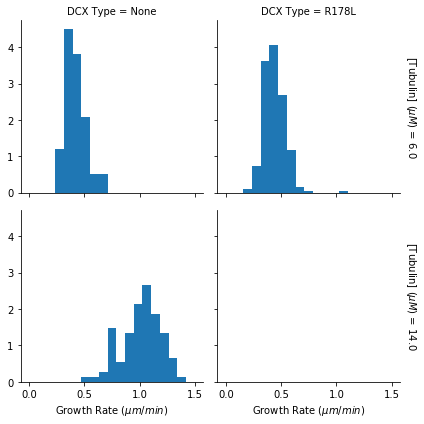

In [57]:
g = sns.FacetGrid(df, row=tubulin, col='DCX Type', margin_titles=True)
bins = np.linspace(0, 1.5, 20)
g.map(plt.hist, GrowthRate, bins=bins, density=True)

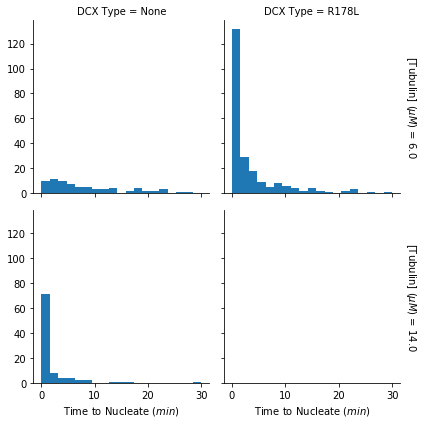

In [58]:
g = sns.FacetGrid(df, row=tubulin, col="DCX Type", margin_titles=True)
bins = np.linspace(0, 30, 20)
g.map(plt.hist, TimeToNucleate, bins=bins)

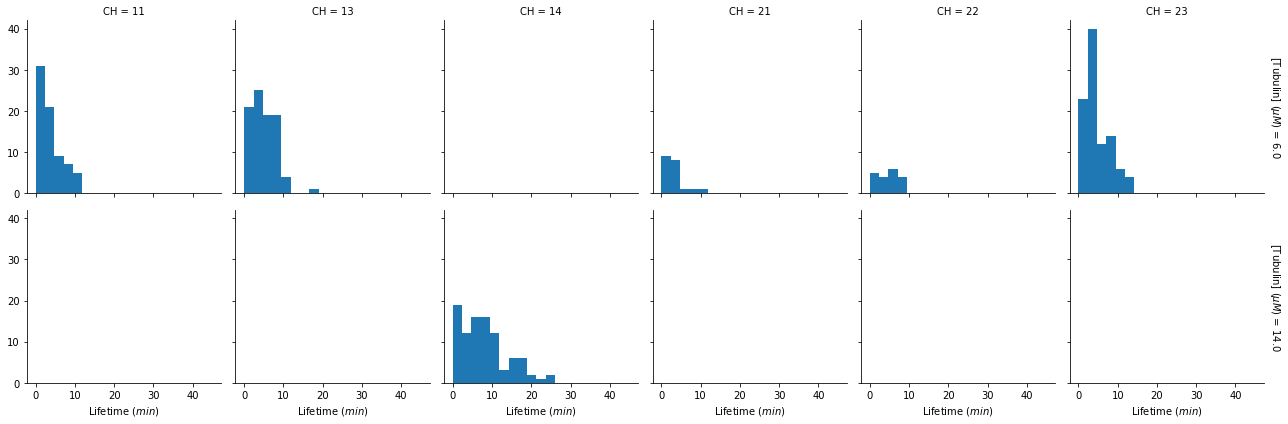

In [59]:
g = sns.FacetGrid(df, row=tubulin, col="CH", margin_titles=True)
bins = np.linspace(0, 45, 20)
g.map(plt.hist, Lifetime, bins=bins)

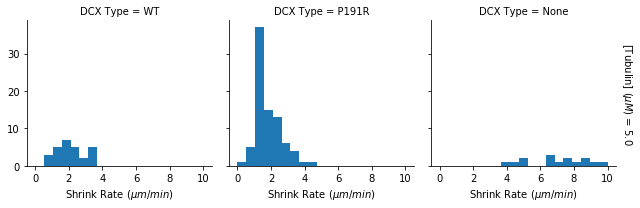

In [53]:
g = sns.FacetGrid(df, row=tubulin, col="DCX Type", margin_titles=True)
bins = np.linspace(0, 10, 20)
g.map(plt.hist, ShrinkageRate, bins=bins)